In [1]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import sem
from scipy.special import binom
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import anndata
import scanpy
import string
from tqdm import tqdm

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [2]:
# Load postprocessed MERFISH and MACA results

# Define the path of the analyzed MERFISH data
dataPathPost = '../../../results'

# Define the experiments
experimentName = ['MsLiver_Cellbound_VZG116_V1_JH_09-18-2021', 
                  'MsKidney_CellBoundary_VZG116_111921']
prefixCountsFilter = ''
suffixCountsFilter = '_FilteredSingleCellCounts.h5ad'

VizgenCountsFilter = []

# QC filtering criteria
min_transcripts = 20
min_DAPI = 600
min_volume = 80
max_volume = 2000

for i in range(len(experimentName)):
    # Filtered counts per segmented cell
    VizgenCountsFilter.append(anndata.read_h5ad(os.path.join(dataPathPost, prefixCountsFilter, 
                                                        experimentName[i] + suffixCountsFilter)))

# Convert all gene names to lower case
for i in range(len(experimentName)):
    VizgenCountsFilter[i].var.index = VizgenCountsFilter[i].var.index.str.lower()
    
# Rename the 5 genes that are inconsistent with MACA (NOTE: MIR205HG doesn't seem to be in MACA at all)
rename_map = {'mir205hg':'4631405k08rik',
             'ackr1':'darc',
             'adgrl4':'eltd1',
             'cavin2':'sdpr',
             'jchain':'igj'}
for i in range(len(experimentName)):
    gene_list = list(VizgenCountsFilter[i].var.index)
    for j in range(len(gene_list)):
        if gene_list[j] in rename_map.keys():
            gene_list[j] = rename_map[gene_list[j]]
    VizgenCountsFilter[i].var.index = gene_list

# Combine into single tissue objects
liver_ind = [0]
kidney_ind = [1]
VizgenLiver_all = []
VizgenKidney_all = []

for i in liver_ind:
    VizgenLiver_all.append(VizgenCountsFilter[i])
    
for i in kidney_ind:
    VizgenKidney_all.append(VizgenCountsFilter[i])

VizgenLiver = VizgenLiver_all[0]
for i in range(len(liver_ind)-1):
    VizgenLiver = VizgenLiver.concatenate(VizgenLiver_all[i+1])
    
VizgenKidney = VizgenKidney_all[0]
for i in range(len(kidney_ind)-1):
    VizgenKidney = VizgenKidney.concatenate(VizgenKidney_all[i+1])
    
# Load raw MACA data (10x)
dataPathMACA = '/mnt/ibm_lg/angela/'
experimentMACA10x = 'tabula-muris-senis-droplet-official-raw-obj.h5ad'
MACA_10x = anndata.read(os.path.join(dataPathMACA, experimentMACA10x))

# Use only 3 month old mice
ind = MACA_10x.obs['age'] == '3m'
MACA_10x = MACA_10x[ind]

# Select only the tissue-specific cells from the raw datasets
MACAliver_10x= MACA_10x[MACA_10x.obs['tissue'] == 'Liver'].copy()
MACAkidney_10x= MACA_10x[MACA_10x.obs['tissue'] == 'Kidney'].copy()

# Convert genes to lower case
MACAliver_10x.var.index = MACAliver_10x.var.index.str.lower()
MACAkidney_10x.var.index = MACAkidney_10x.var.index.str.lower()

# Select shared gene panel genes only
genes_Vizgen = VizgenCountsFilter[0].var.index
genes_10x = MACAliver_10x.var.index
genes_shared = genes_Vizgen.intersection(genes_10x) # List of shared genes


VizgenLiver = VizgenLiver[:, genes_shared].copy()
VizgenKidney = VizgenKidney[:, genes_shared].copy()
MACAliver_10x = MACAliver_10x[:, genes_shared]
MACAkidney_10x = MACAkidney_10x[:, genes_shared]

# Final check for uppercase genes in Vizgen data and correct if needed
VizgenLiver.var.index = VizgenLiver.var.index.str.lower()
VizgenKidney.var.index = VizgenKidney.var.index.str.lower()
    
print('Processed data loaded.')

Processed data loaded.


### Panel A: comparison of mean levels across cells with nonzero counts between MERFISH and scRNA-seq

In [3]:
# Dataframe to store summary statistics
summary_liver = pd.DataFrame(index=genes_shared,
                            columns=['mean_MERFISH',
                                    'sem_MERFISH',
                                    'var_MERFISH',
                                    'CV_MERFISH',
                                    'N_MERFISH',
                                    'mean_scRNAseq',
                                    'sem_scRNAseq',
                                    'var_scRNAseq',
                                    'CV_scRNAseq',
                                    'N_scRNAseq'])
summary_kidney = pd.DataFrame(index=genes_shared,
                            columns=['mean_MERFISH',
                                    'sem_MERFISH',
                                    'var_MERFISH',
                                    'CV_MERFISH',
                                    'N_MERFISH',
                                    'mean_scRNAseq',
                                    'sem_scRNAseq',
                                    'var_scRNAseq',
                                    'CV_scRNAseq',
                                    'N_scRNAseq'])

# Calculate summary statistics among cells with more than 0 counts
min_counts = 0
VizgenLiver_dist = {}
VizgenKidney_dist = {}
MACAliver_10x_dist = {}
MACAkidney_10x_dist = {}

for gene in tqdm(genes_shared, desc='Calculating summary statistics'):
    VizgenLiver_gene = VizgenLiver[:,gene].X.toarray().copy()
    VizgenLiver_gene = VizgenLiver_gene[VizgenLiver_gene > min_counts]
    
    summary_liver.loc[gene, 'mean_MERFISH'] = np.mean(VizgenLiver_gene)
    summary_liver.loc[gene, 'var_MERFISH'] = np.var(VizgenLiver_gene)
    summary_liver.loc[gene, 'sem_MERFISH'] = sem(VizgenLiver_gene)
    summary_liver.loc[gene, 'CV_MERFISH'] = np.std(VizgenLiver_gene) / np.mean(VizgenLiver_gene)
    summary_liver.loc[gene, 'N_MERFISH'] = len(VizgenLiver_gene)
    VizgenLiver_dist[gene] = VizgenLiver_gene
    
    MACAliver_10x_gene = MACAliver_10x[:,gene].X.toarray().copy()
    MACAliver_10x_gene = MACAliver_10x_gene[MACAliver_10x_gene > min_counts]
    
    summary_liver.loc[gene, 'mean_scRNAseq'] = np.mean(MACAliver_10x_gene)
    summary_liver.loc[gene, 'var_scRNAseq'] = np.var(MACAliver_10x_gene)
    summary_liver.loc[gene, 'sem_scRNAseq'] = sem(MACAliver_10x_gene)
    summary_liver.loc[gene, 'CV_scRNAseq'] = np.std(MACAliver_10x_gene) / np.mean(MACAliver_10x_gene)
    summary_liver.loc[gene, 'N_scRNAseq'] = len(MACAliver_10x_gene)
    MACAliver_10x_dist[gene] = MACAliver_10x_gene
    
    VizgenKidney_gene = VizgenKidney[:,gene].X.toarray().copy()
    VizgenKidney_gene = VizgenKidney_gene[VizgenKidney_gene > min_counts]
    
    summary_kidney.loc[gene, 'mean_MERFISH'] = np.mean(VizgenKidney_gene)
    summary_kidney.loc[gene, 'var_MERFISH'] = np.var(VizgenKidney_gene)
    summary_kidney.loc[gene, 'sem_MERFISH'] = sem(VizgenKidney_gene)
    summary_kidney.loc[gene, 'CV_MERFISH'] = np.std(VizgenKidney_gene) / np.mean(VizgenKidney_gene)
    summary_kidney.loc[gene, 'N_MERFISH'] = len(VizgenKidney_gene)
    VizgenKidney_dist[gene] = VizgenKidney_gene
    
    MACAkidney_10x_gene = MACAkidney_10x[:,gene].X.toarray().copy()
    MACAkidney_10x_gene = MACAkidney_10x_gene[MACAkidney_10x_gene > min_counts]
    
    summary_kidney.loc[gene, 'mean_scRNAseq'] = np.mean(MACAkidney_10x_gene)
    summary_kidney.loc[gene, 'var_scRNAseq'] = np.var(MACAkidney_10x_gene)
    summary_kidney.loc[gene, 'sem_scRNAseq'] = sem(MACAkidney_10x_gene)
    summary_kidney.loc[gene, 'CV_scRNAseq'] = np.std(MACAkidney_10x_gene) / np.mean(MACAkidney_10x_gene)
    summary_kidney.loc[gene, 'N_scRNAseq'] = len(MACAkidney_10x_gene)
    MACAkidney_10x_dist[gene] = MACAkidney_10x_gene
    
print('Summary statistics calculated.')

# Keep only genes that have enough statistical power (i.e. enough cells)
cutoff_N = 50
summary_liver = summary_liver[(summary_liver['N_MERFISH'] > cutoff_N) &
                              (summary_liver['N_scRNAseq'] > cutoff_N)]
summary_kidney = summary_kidney[(summary_kidney['N_MERFISH'] > cutoff_N) &
                              (summary_kidney['N_scRNAseq'] > cutoff_N)]

Calculating summary statistics:   0%|                                                 | 0/306 [00:00<?, ?it/s]/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/numpy/core/_method

Summary statistics calculated.


Text(0.5, 1.0, 'kidney, R=0.48')

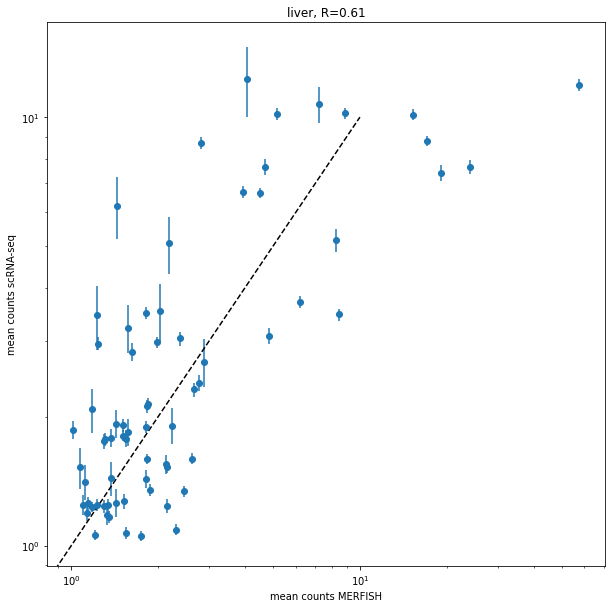

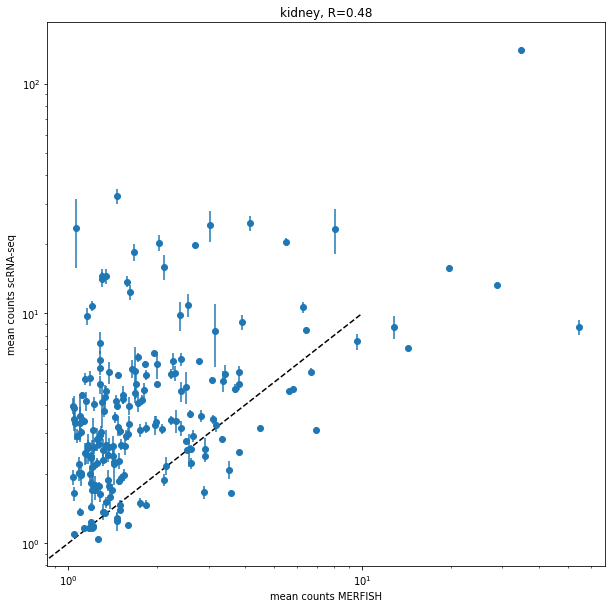

In [4]:
# Plot mean and sem across technologies

# Liver
meancorr_liver = pearsonr(summary_liver['mean_MERFISH'], summary_liver['mean_scRNAseq'])[0]

fig, ax = plt.subplots(figsize=(10,10))
ax.errorbar(summary_liver['mean_MERFISH'],
            summary_liver['mean_scRNAseq'],
            yerr=summary_liver['sem_scRNAseq'],
            xerr=summary_liver['sem_MERFISH'],
            linestyle='',
            marker='o')
ax.plot([0, 10], [0, 10], 'k--')
ax.set_xlabel('mean counts MERFISH')
ax.set_ylabel('mean counts scRNA-seq')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('liver, R=' + str(np.round(meancorr_liver, 2)))

# Kidney
meancorr_kidney = pearsonr(summary_kidney['mean_MERFISH'], summary_kidney['mean_scRNAseq'])[0]

fig, ax = plt.subplots(figsize=(10,10))
ax.errorbar(summary_kidney['mean_MERFISH'],
            summary_kidney['mean_scRNAseq'],
            yerr=summary_kidney['sem_scRNAseq'],
            xerr=summary_kidney['sem_MERFISH'],
            linestyle='',
            marker='o')
ax.plot([0, 10], [0, 10], 'k--')
ax.set_xlabel('mean counts MERFISH')
ax.set_ylabel('mean counts scRNA-seq')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('kidney, R=' + str(np.round(meancorr_kidney, 2)))



### Panel B: mean variance relationship

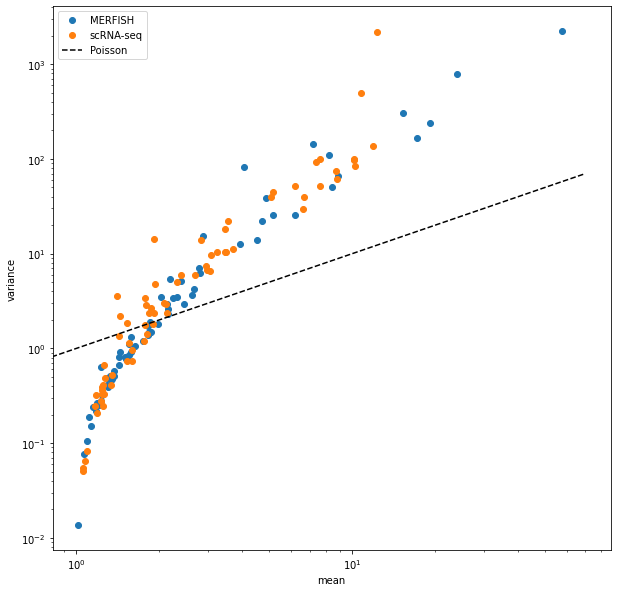

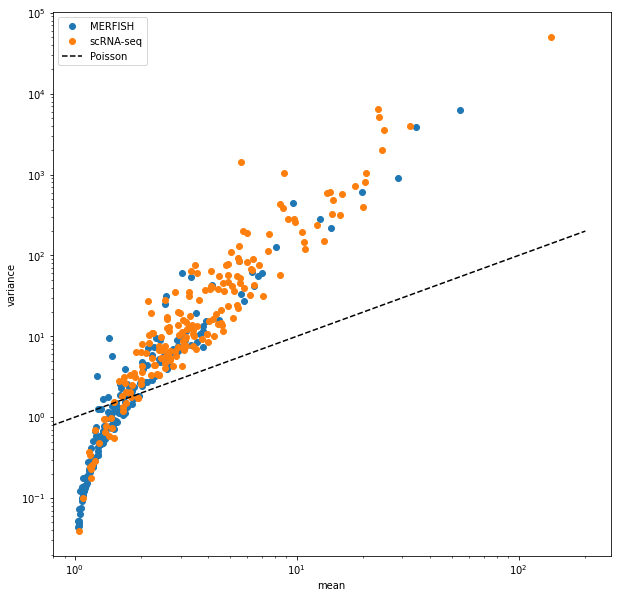

In [5]:
# Liver
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(summary_liver['mean_MERFISH'],
           summary_liver['var_MERFISH'],
           linestyle='',
           marker='o',
           label='MERFISH')
ax.plot(summary_liver['mean_scRNAseq'],
           summary_liver['var_scRNAseq'],
           linestyle='',
           marker='o',
           label='scRNA-seq')
ax.plot([0, 70], [0, 70], 'k--', label='Poisson')
ax.set_xlabel('mean')
ax.set_ylabel('variance')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

# Kidney
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(summary_kidney['mean_MERFISH'],
           summary_kidney['var_MERFISH'],
           linestyle='',
           marker='o',
           label='MERFISH')
ax.plot(summary_kidney['mean_scRNAseq'],
           summary_kidney['var_scRNAseq'],
           linestyle='',
           marker='o',
           label='scRNA-seq')
ax.plot([0, 200], [0, 200], 'k--', label='Poisson')
ax.set_xlabel('mean')
ax.set_ylabel('variance')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

Text(0, 0.5, 'scRNA-seq')

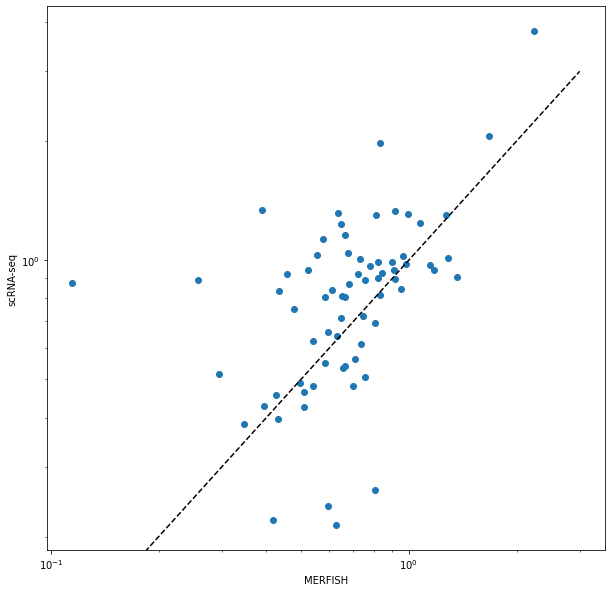

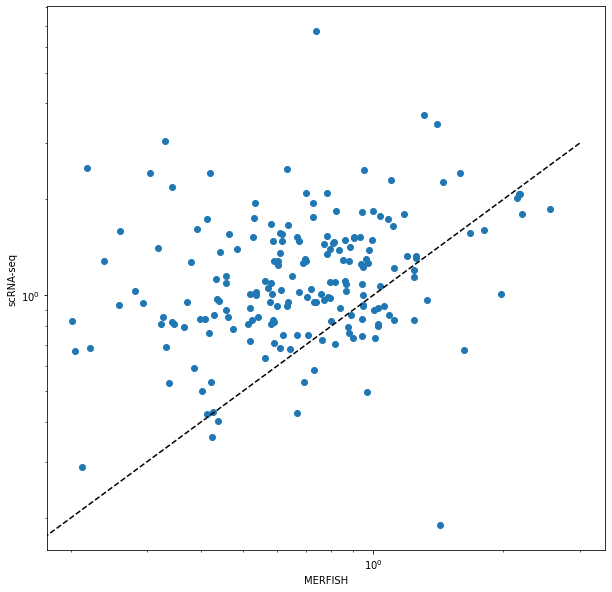

In [6]:
# CV vs CV
# Liver
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(summary_liver['CV_MERFISH'],
           summary_liver['CV_scRNAseq'])
ax.plot([0, 3], [0, 3], 'k--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('MERFISH')
ax.set_ylabel('scRNA-seq')

# Kidney
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(summary_kidney['CV_MERFISH'],
           summary_kidney['CV_scRNAseq'])
ax.plot([0, 3], [0, 3], 'k--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('MERFISH')
ax.set_ylabel('scRNA-seq')

In [7]:
# Fit single cell distributions

# Negative binomial PMF -- support is k, r and p are hyperparameters
def neg_binomial(k,r,p):
    return binom(k+r-1, r-1) * (1-p)**r * p**k

# Function to calculate distributions fits
def fit_dist(data, results):
    # Check if there are enough unique values
    min_unique = 30
    
    if len(np.unique(data)) < min_unique:
        results.loc[gene] = np.nan
    
    else:
        # Bin the data
        num_bins = 30
        frequencies, bin_edges = np.histogram(data, num_bins, density=True)
        central_values = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])

        p0 = [1, 0.5]

        try:
            popt, pcov = curve_fit(neg_binomial, central_values, frequencies, p0=p0, bounds=([0,0], [np.inf, 1]), verbose=0)
            r = popt[0]
            p = popt[1]

            # Calculate fitted PDF and error with fit in distribution
            pdf_values = [neg_binomial(c,r,p) for c in central_values]

            # Calculate sum of squared error
            sse = np.sum(np.power(frequencies - pdf_values, 2.0))

            results.loc[gene, 'SSE'] = sse
            results.loc[gene, 'r'] = r
            results.loc[gene, 'p'] = p

        except RuntimeError:
            results.loc[gene] = np.nan
            #print('failed to fit')
            
results_liver = pd.DataFrame(index=genes_shared, columns=['SSE', 'r', 'p'])
results_kidney = pd.DataFrame(index=genes_shared, columns=['SSE', 'r', 'p'])


for gene in tqdm(genes_shared, desc='Fitting distributions to data...'):
    fit_dist(VizgenLiver_dist[gene], results_liver)
    fit_dist(VizgenKidney_dist[gene], results_kidney)

Fitting distributions to data...: 100%|█████████████████████████████████████| 306/306 [00:03<00:00, 98.80it/s]


### Plot combined figure

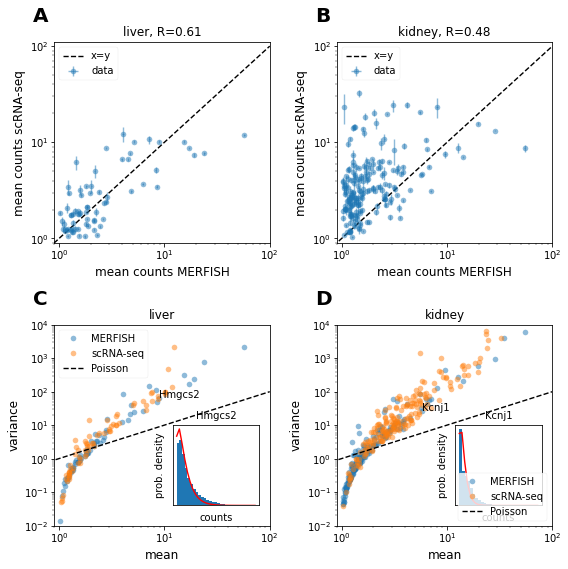

In [12]:
set_plotting_style()

# # Inset
# # barplots
# ax1 = ax[0].inset_axes([2, -9, 6, 4], transform=ax[0].transData)
# x_bar = [4,5]
# y_bar = [coord_df.loc[('liver','heart'),'macrophage'], coord_control_df_mean.loc[('liver','heart'),'macrophage']]
# y_err = [0, coord_control_df_sd.loc[('liver','heart'),'macrophage']]
# colors = ['tab:blue','tab:gray']

# ax1.bar(x_bar, y_bar, yerr=y_err, width=0.5, capsize=4, color=colors)
# ax1.set_ylim((0,1))
# ax1.set_yticks([0,1])
# #ax1.legend()


# Plot the whole figure
fig, axes = plt.subplots(2,2, figsize=(8,8))

# Panel A
ax = axes[0,0]
ax.errorbar(summary_liver['mean_MERFISH'],
            summary_liver['mean_scRNAseq'],
            yerr=summary_liver['sem_scRNAseq'],
            xerr=summary_liver['sem_MERFISH'],
            linestyle='',
            marker='o',
            alpha=0.5,
            label='data')
ax.plot([0, 100], [0, 100], 'k--', label='x=y')
ax.set_xlabel('mean counts MERFISH')
ax.set_ylabel('mean counts scRNA-seq')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('liver, R=' + str(np.round(meancorr_liver, 2)))
ax.set_xlim(0.9, 100)
ax.set_ylim(0.9, 110)
ax.legend()

# Panel B
ax = axes[0,1]
ax.errorbar(summary_kidney['mean_MERFISH'],
            summary_kidney['mean_scRNAseq'],
            yerr=summary_kidney['sem_scRNAseq'],
            xerr=summary_kidney['sem_MERFISH'],
            linestyle='',
            marker='o',
            alpha=0.5,
            label='data')
ax.plot([0, 100], [0, 100], 'k--', label='x=y')
ax.set_xlabel('mean counts MERFISH')
ax.set_ylabel('mean counts scRNA-seq')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('kidney, R=' + str(np.round(meancorr_kidney, 2)))
ax.set_xlim(0.9, 100)
ax.set_ylim(0.9, 110)
ax.legend()

# Panel C
ax = axes[1,0]
ax.plot(summary_liver['mean_MERFISH'],
           summary_liver['var_MERFISH'],
           linestyle='',
           marker='o',
           label='MERFISH',
           alpha=0.5)
ax.plot(summary_liver['mean_scRNAseq'],
           summary_liver['var_scRNAseq'],
           linestyle='',
           marker='o',
           label='scRNA-seq',
           alpha=0.5)
ax.plot([0, 100], [0, 100], 'k--', label='Poisson')
ax.set_xlabel('mean')
ax.set_ylabel('variance')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('liver')
ax.set_xlim(0.9, 100)
ax.set_ylim(0.01, 10000)
ax.legend()

# Panel C inset
gene = 'hmgcs2'
bins = np.linspace(0,60,30)

ax1 = ax.inset_axes([0.55, 0.1, 0.4, 0.4])
ax1.hist(VizgenLiver_dist[gene], bins=bins, density=True)
ax1.plot(bins, neg_binomial(bins, results_liver.loc[gene]['r'], results_liver.loc[gene]['p']), 'r-')
ax1.set_xlabel('counts', size=10)
ax1.set_ylabel('prob. density', size=10)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title(gene.capitalize(), size=10)

ax.text(summary_liver.loc[gene,'mean_MERFISH'], summary_liver.loc[gene,'var_MERFISH'], gene.capitalize())

# Panel D
ax = axes[1,1]
ax.plot(summary_kidney['mean_MERFISH'],
           summary_kidney['var_MERFISH'],
           linestyle='',
           marker='o',
           label='MERFISH',
           alpha=0.5)
ax.plot(summary_kidney['mean_scRNAseq'],
           summary_kidney['var_scRNAseq'],
           linestyle='',
           marker='o',
           label='scRNA-seq',
           alpha=0.5)
ax.plot([0, 100], [0, 100], 'k--', label='Poisson')
ax.set_xlabel('mean')
ax.set_ylabel('variance')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('kidney')
ax.set_xlim(0.9, 100)
ax.set_ylim(0.01, 10000)
ax.legend()

# Panel D inset
gene = 'kcnj1'
bins = np.linspace(0,60,30)

ax1 = ax.inset_axes([0.55, 0.1, 0.4, 0.4])
ax1.hist(VizgenKidney_dist[gene], bins=bins, density=True)
ax1.plot(bins, neg_binomial(bins, results_kidney.loc[gene]['r'], results_kidney.loc[gene]['p']), 'r-')
ax1.set_xlabel('counts', size=10)
ax1.set_ylabel('prob. density', size=10)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title(gene.capitalize(), size=10)

ax.text(summary_kidney.loc[gene,'mean_MERFISH'], summary_kidney.loc[gene,'var_MERFISH'], gene.capitalize())

# Label subpanels
axes_flat = axes.flat
for n, ax in enumerate(axes_flat):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
plt.show()

In [13]:
# Export figures
fig.savefig('../../figures/Fig5_singlecelldistributions.svg', transparent=True)
fig.savefig('../../figures/Fig5_singlecelldistributions.png', transparent=True)

print('Figures saved.')

Figures saved.
